Total observations: 1892

Descriptive Statistics:
       touches_opp_box
count      1892.000000
mean         25.526956
std          12.245152
min           2.000000
25%          17.000000
50%          23.000000
75%          32.000000
max         104.000000

REGRESSION RESULTS
Coefficient (slope): 0.0463
Intercept: 0.2770
R-squared: 0.4264
RMSE: 0.6573

Interpretation: Each additional touch in the opposition box
is associated with an increase of 0.0463 expected goals


TypeError: unsupported operand type(s) for -: 'str' and 'float'

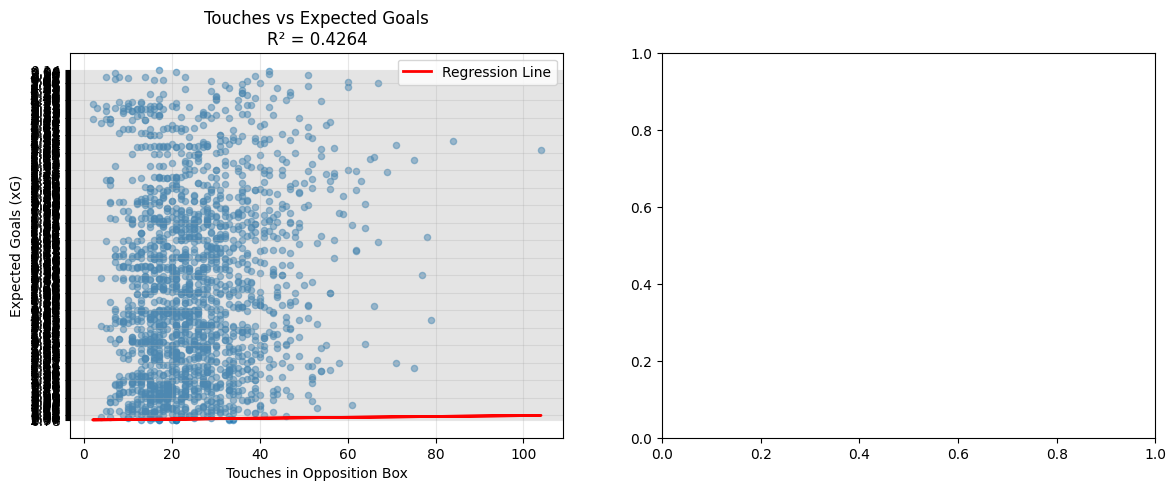

In [11]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
conn = sqlite3.connect(r'/Users/admin/Documents/dev/algobetting/infra/data/db/fotmob.db')
df = pd.read_sql_query("""
    SELECT
        match_id,
        home_touches_opp_box,
        away_touches_opp_box,
        home_expected_goals,
        away_expected_goals
    FROM
        match_stats
    WHERE
        home_touches_opp_box IS NOT NULL
""", conn)

# Reshape data to have one row per team per match
home_data = df[['match_id', 'home_touches_opp_box', 'home_expected_goals']].copy()
home_data.columns = ['match_id', 'touches_opp_box', 'expected_goals']

away_data = df[['match_id', 'away_touches_opp_box', 'away_expected_goals']].copy()
away_data.columns = ['match_id', 'touches_opp_box', 'expected_goals']

# Combine home and away data
combined_df = pd.concat([home_data, away_data], ignore_index=True)

# Remove any null values
combined_df = combined_df.dropna()

print(f"Total observations: {len(combined_df)}")
print(f"\nDescriptive Statistics:")
print(combined_df[['touches_opp_box', 'expected_goals']].describe())

# Prepare data for regression
X = combined_df[['touches_opp_box']]
y = combined_df['expected_goals']

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Calculate metrics
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Print results
print(f"\n{'='*50}")
print("REGRESSION RESULTS")
print(f"{'='*50}")
print(f"Coefficient (slope): {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"\nInterpretation: Each additional touch in the opposition box")
print(f"is associated with an increase of {model.coef_[0]:.4f} expected goals")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot with regression line
axes[0].scatter(X, y, alpha=0.5, s=20)
axes[0].plot(X, y_pred, color='red', linewidth=2, label='Regression Line')
axes[0].set_xlabel('Touches in Opposition Box')
axes[0].set_ylabel('Expected Goals (xG)')
axes[0].set_title(f'Touches vs Expected Goals\nR² = {r2:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted xG')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Correlation
correlation = combined_df['touches_opp_box'].corr(combined_df['expected_goals'])
print(f"\nPearson Correlation: {correlation:.4f}")